<a href="https://colab.research.google.com/github/wojiushilr/ML_hw/blob/master/LSA_use_SVD_NMF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Topic Modeling with NMF and SVD

### The problem
You can refer to this [link](https://github.com/fastai/course-nlp/blob/master/2-svd-nmf-topic-modeling.ipynb)

We can decompose the term-document matrix into one tall thin matrix times one wide short matrix (possibly with a diagonal matrix in between).

Notice that this representation does not take into account word order or sentence structure. It's an example of a **bag of words** approach.

Latent Semantic Analysis (LSA) uses Singular Value Decomposition (SVD).

### Get start
We will try this with two different matrix factorizations: **Singular Value Decomposition (SVD)** and **Non-negative Matrix Factorization (NMF)**

In [ ]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt

In [ ]:
%matplotlib inline
np.set_printoptions(suppress=True)

In [ ]:
fetch_20newsgroups

<function sklearn.datasets._twenty_newsgroups.fetch_20newsgroups>

### Explore the dataset
We use the sklearn build-in dataset. **Newsgroups**  
Newsgroups are discussion groups on Usenet, which was popular in the 80s and 90s before the web really took off. This dataset includes 18,000 newsgroups posts with 20 topics.

In [ ]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

In [ ]:
print(type(newsgroups_train))

<class 'sklearn.utils.Bunch'>


In [ ]:
newsgroups_train.filenames.shape, newsgroups_train.target.shape

((2034,), (2034,))

In [ ]:
print("\n".join(newsgroups_train.data[:1]))

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


#### The target attribute is the integer index of the category.

In [ ]:
[newsgroups_train.target[:3]]

[array([1, 3, 2])]

#### Look insight of the target name

In [ ]:
np.array(newsgroups_train.target_names)[np.array([1,3,2])]

array(['comp.graphics', 'talk.religion.misc', 'sci.space'], dtype='<U18')

In [ ]:
num_topics, num_top_words = 6, 8

### Stop words, stemming, lemmatization
This tech is a little bit out of style. Because for not this information also useful for the complex start-of-art method today.  
However, for this task, we use some reletively simple method like SVD, so we only extract the important information.


These were long considered standard techniques, but they can often **hurt your performance if using deep learning**. Stemming, lemmatization, and removing stop words all involve throwing away information.

However, they can still be useful when working with simpler models.

In [ ]:
from sklearn.feature_extraction import stop_words

sorted(list(stop_words.ENGLISH_STOP_WORDS))[:20]

['a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amoungst']

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from nltk import stem

In [ ]:
wnl = stem.WordNetLemmatizer()
porter = stem.porter.PorterStemmer()

In [ ]:
word_list = ['feet', 'foot', 'foots', 'footing']

In [ ]:
[wnl.lemmatize(word) for word in word_list]

['foot', 'foot', 'foot', 'footing']

In [ ]:
[porter.stem(word) for word in word_list]

['feet', 'foot', 'foot', 'foot']

In [ ]:
import spacy

In [ ]:
from spacy.lemmatizer import Lemmatizer
from spacy.lookups import Lookups
lookups = Lookups()
lemmatizer = Lemmatizer(lookups)

In [ ]:
[lemmatizer.lookup(word) for word in word_list]

['feet', 'foot', 'foots', 'footing']

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk

### Get our vector
scikit learn has a method that will extract all the word counts for us, which call CountVectorizer

In [ ]:
vectorizer = CountVectorizer(stop_words='english') #, tokenizer=LemmaTokenizer())
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

#### **.todense** 
returns a matrix. and toarray returns an ndarray;If you want a matrix, use todense; otherwise, use toarray.

即将矩阵显示出来


In [ ]:
vectors = vectorizer.fit_transform(newsgroups_train.data).todense()
vectors

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
vectors = vectorizer.fit_transform(newsgroups_train.data).todense() # (documents, vocab)
vectors.shape #, vectors.nnz / vectors.shape[0], row_means.shape
print(len(newsgroups_train.data), vectors.shape)

2034 (2034, 26576)


Vocab will have 26576 feature. So it will be a quite sparse matrix 

In [ ]:
vectors[0].shape

(1, 26576)

In [ ]:
vocab = np.array(vectorizer.get_feature_names())
vocab.shape

(26576,)

### Singular Value Decomposition (SVD)

The SVD algorithm factorizes a matrix into one matrix with **orthogonal columns** and one with **orthogonal rows** (between with a diagonal matrix, which contains the relative importance of each factor).

SVD is an exact decomposition, since the matrices it creates are big enough to fully cover the original matrix.   
SVD is extremely widely used in linear algebra, and specifically in data science, including:
- semantic analysis
- collaborative filtering/recommendations (winning entry for Netflix Prize)
- calculate Moore-Penrose pseudoinverse
- data compression
- principal component analysis (PCA)

In [ ]:
%time U, s, Vh = linalg.svd(vectors, full_matrices=False)

CPU times: user 1min 14s, sys: 3.91 s, total: 1min 18s
Wall time: 40.7 s


In [ ]:
print(U.shape, s.shape, Vh.shape)
# (2034, 2034) (2034,) (2034, 26576)
# 2034: document number
# 26576: vocab number

(2034, 2034) (2034,) (2034, 26576)


Confirm this is a decomposition of the input.

In [ ]:
s[:4]

array([433.92698542, 291.51012741, 240.71137677, 220.00048043])

In [ ]:
np.diag(s[:4])

array([[433.92698542,   0.        ,   0.        ,   0.        ],
       [  0.        , 291.51012741,   0.        ,   0.        ],
       [  0.        ,   0.        , 240.71137677,   0.        ],
       [  0.        ,   0.        ,   0.        , 220.00048043]])

Confrim that U, s, Vh is a decomposition of `vectors`

In [ ]:
reconstruct_vector1 = np.dot(U, np.diag(s))
reconstruct_vector = np.dot(reconstruct_vector1, Vh)
np.allclose(reconstruct_vector, vectors)

True

Confirm that U, Vh are orthonormal

In [ ]:
np.allclose(U.T @ U, np.eye(U.shape[0]))
np.allclose(Vh @ Vh.T, np.eye(Vh.shape[0]))

True

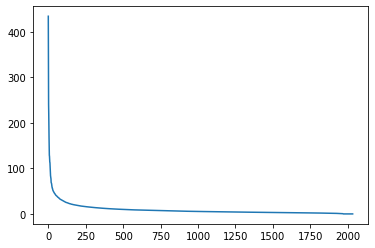

In [ ]:
plt.plot(s)

In [ ]:
Vh[:5].shape

(5, 26576)

In [ ]:
num_top_words=8

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [ ]:
show_topics(Vh[:5])

['ditto critus propagandist surname galacticentric kindergarten surreal imaginative',
 'jpeg gif file color quality image jfif format',
 'graphics edu pub mail 128 3d ray ftp',
 'jesus god matthew people atheists atheism does graphics',
 'image data processing analysis software available tools display']

In [ ]:
vectors.shape

(2034, 26576)

### NMF

In [ ]:
m,n=vectors.shape
d=5  # num topics

In [ ]:
# vectors.T.shape

(26576, 2034)

In [ ]:
clf = decomposition.NMF(n_components=d, random_state=1)

W1 = clf.fit_transform(vectors)
H1 = clf.components_

In [ ]:
print(W1.shape, H1.shape)

(2034, 5) (5, 26576)


In [ ]:
show_topics(H1)

['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray ftp send',
 'space launch satellite nasa commercial satellites year market',
 'jesus god people matthew atheists does atheism said',
 'image data available software processing ftp edu analysis']

### Other small demo of LSA for looking the insight

In [ ]:
from sklearn.decomposition import TruncatedSVD           # namely LSA/LSI(即潜在语义分析)
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

In [ ]:
docs = ["In the middle of the night",
        "When our hopes and fears collide",
        "In the midst of all goodbyes",
        "Where all human beings lie",
        "Against another lie"]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(docs).todense()
terms = vectorizer.get_feature_names()
print(X.shape, type(X))
print(X)
print(X.tolist()[0][0])
print(len(terms), terms)

(5, 20) <class 'numpy.matrix'>
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.3319971  0.
  0.41150185 0.         0.41150185 0.3319971  0.         0.6639942
  0.         0.        ]
 [0.         0.         0.40824829 0.         0.         0.40824829
  0.40824829 0.         0.40824829 0.         0.         0.
  0.         0.         0.         0.         0.40824829 0.
  0.40824829 0.        ]
 [0.         0.37601977 0.         0.         0.         0.
  0.         0.46606681 0.         0.         0.37601977 0.
  0.         0.46606681 0.         0.37601977 0.         0.37601977
  0.         0.        ]
 [0.         0.38898761 0.         0.         0.48214012 0.
  0.         0.         0.         0.48214012 0.         0.38898761
  0.         0.         0.         0.         0.         0.
  0.         0.48214012]
 [0.61418897 0.         0.         0.61418897 0.         0.
  0.         0.         0.         0.         0.         0

In [ ]:
n_pick_topics = 3            # 设定主题数为3
lsa = TruncatedSVD(n_pick_topics)               
X2 = lsa.fit_transform(X)
print(lsa)
X2

TruncatedSVD(algorithm='randomized', n_components=3, n_iter=5,
             random_state=None, tol=0.0)


array([[ 0.8266298 , -0.2469059 , -0.        ],
       [ 0.        ,  0.        ,  1.        ],
       [ 0.86668208, -0.09090296,  0.        ],
       [ 0.28009907,  0.72866996, -0.        ],
       [ 0.10312364,  0.76397584, -0.        ]])

X2[i,t]为第i篇文档在第t个主题上的分布，所以该值越高的文档i，可以认为在主题t上更有代表性，我们便以此筛选出最能代表该主题的**2篇文档**。

In [ ]:
n_pick_docs= 2
topic_docs_id = [X2[:,t].argsort()[:-(n_pick_docs+1):-1] for t in range(n_pick_topics)] # [:-(n_pick_docs+!):-1] 为切片操作， 选后两个元素
topic_docs_id

[array([2, 0]), array([4, 3]), array([1, 2])]

lsa.components_ 为规模为(主题数，词汇数)的矩阵,其(t,j)位置的元素代表了词语j在主题t上的权重，同样以此获得主题关键词： **这里我们选最重要的4个**

In [ ]:
n_pick_keywords = 4
topic_keywords_id = [lsa.components_[t].argsort()[:-(n_pick_keywords+1):-1] for t in range(n_pick_topics)]
topic_keywords_id

[array([17, 15, 10,  1]), array([11,  0,  3, 19]), array([ 2, 18,  5, 16])]

summary

In [ ]:
for t in range(n_pick_topics):
    print("topic %d:" % t)
    print("    keywords: %s" % ", ".join(terms[topic_keywords_id[t][j]] for j in range(n_pick_keywords)))
    for i in range(n_pick_docs):
        print("    doc %d" % i)
        print("\t"+docs[topic_docs_id[t][i]])

topic 0:
    keywords: the, of, in, all
    doc 0
	In the midst of all goodbyes
    doc 1
	In the middle of the night
topic 1:
    keywords: lie, against, another, where
    doc 0
	Against another lie
    doc 1
	Where all human beings lie
topic 2:
    keywords: and, when, collide, our
    doc 0
	When our hopes and fears collide
    doc 1
	In the midst of all goodbyes


### Some Reference
**Additional Resources**
- Data source: Newsgroups are discussion groups on Usenet, which was popular in the 80s and 90s before the web really took off. This dataset includes 18,000 newsgroups posts with 20 topics.
- Chris Manning's book chapter on matrix factorization and LSI
- Scikit learn truncated SVD LSI details

**Other Tutorials**
- Scikit-Learn: Out-of-core classification of text documents: uses Reuters-21578 dataset (Reuters articles labeled with ~100 categories), HashingVectorizer
- Text Analysis with Topic Models for the Humanities and Social Sciences: uses British and French Literature dataset of Jane Austen, Charlotte Bronte, Victor Hugo, and more